In [1]:
# read the data and do K means over the partitions

In [2]:
# consider running zscore values

In [3]:
import pandas, seaborn, os, numpy
import sklearn, sklearn.cluster

In [4]:
%matplotlib inline
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4), 'axes.labelsize':20})

# 0. user-defined variables

In [5]:
#! drangajokull
home_dir = '/home/adrian/'

#! necio5
#home_dir = '/Users/adrian/'

In [6]:
full_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_FULL.csv'
partial_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_partial.csv'
scratch_dir = home_dir + 'scratch/'

In [7]:
days = [7, 14, 21, 28, 60]

# 1. read data

In [8]:
profiles = pandas.read_csv(full_wound_metabolic_file, index_col=0)

print(profiles.shape)
profiles.head()

(244, 5)


,logFC07,logFC14,logFC21,logFC28,logFC60
mz,,,,,
60.0452_pos,-0.083854,0.191472,0.982798,0.988894,0.743300
60.05658_pos,-0.038624,0.089157,0.781340,0.774211,0.811386
62.02452_pos,1.505635,1.319179,1.076527,1.081010,0.233993
71.02976_pos,1.279493,0.952287,0.857605,0.819389,0.030744
73.53242_pos,1.519172,1.332466,1.114554,1.120287,0.153851


# 2. visualization and formatting

In [9]:
print(profiles.max())
print(profiles.min())

logFC07    4.320985
logFC14    3.439377
logFC21    3.412568
logFC28    3.264995
logFC60    2.410605
dtype: float64
logFC07   -1.666439
logFC14   -1.229001
logFC21   -0.191666
logFC28   -0.289494
logFC60   -0.894508
dtype: float64


In [25]:
a = profiles.max(axis=1).to_list()
b = profiles.min(axis=1).to_list()
for i in range(len(a)):
    diff = abs(a[i] - b[i])
    if diff < numpy.log2(1.75):
        print(a[i], b[i], diff)

0.6927274680700108 -0.0955987649792193 0.7883262330492301
0.9077684039123232 0.1552095236758309 0.7525588802364922
1.0617807185565136 0.2626839108393354 0.7990968077171782
0.7695048146110032 0.0361291555596226 0.7333756590513806
1.0684430155173696 0.2717063065333767 0.796736708983993
0.9794713586934152 0.2161151326975322 0.763356225995883
0.995913418258253 0.1890155595051411 0.8068978587531119
0.9941189557786302 0.1941583278954602 0.79996062788317
0.8977662505136887 0.1095673256993303 0.7881989248143585


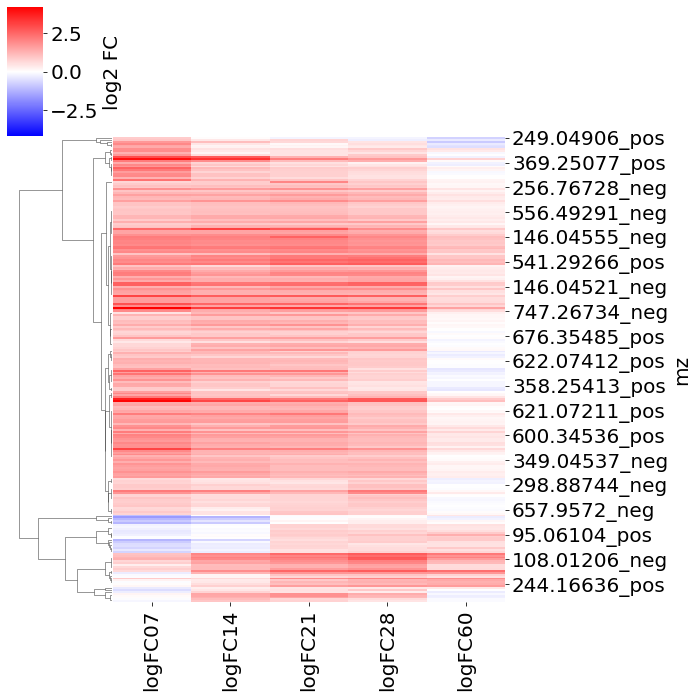

In [10]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(profiles, cmap='bwr', vmin=-4.25, vmax=4.25, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'log2 FC'})

In [11]:
x = profiles.to_numpy()
x

array([[-0.08385417,  0.19147181,  0.98279782,  0.9888938 ,  0.74330046],
       [-0.03862367,  0.08915717,  0.78133973,  0.77421073,  0.81138562],
       [ 1.50563522,  1.31917937,  1.07652701,  1.08101019,  0.23399308],
       ...,
       [ 0.63033308,  0.3660165 ,  0.63618429,  0.64272835, -0.29498476],
       [ 0.93145449,  1.04982251,  1.12161224,  0.91999787,  0.25556203],
       [ 0.84806665,  0.84048413,  0.89776625,  0.77620353,  0.10956733]])

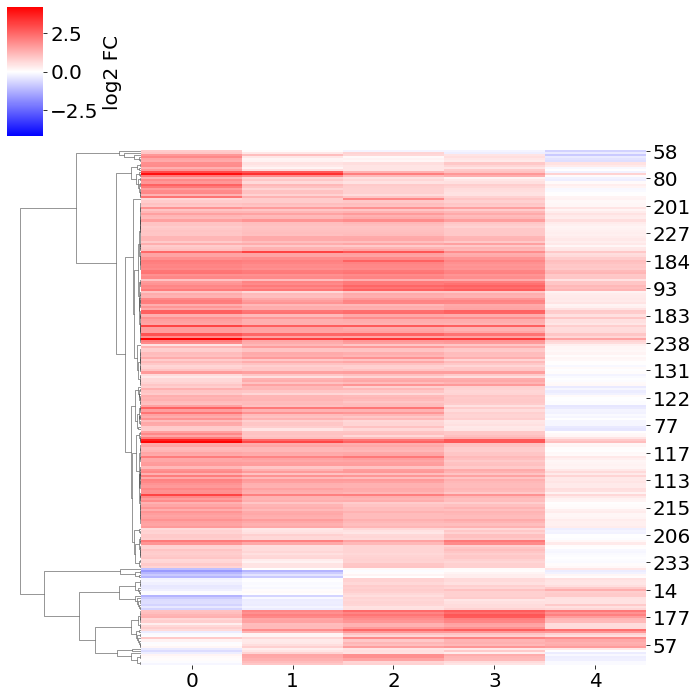

In [12]:
seaborn.clustermap(x, cmap='bwr', vmin=-4.25, vmax=4.25, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'log2 FC'})

# 3. analysis

In [13]:
number_elements = profiles.shape[0]
print('number of elements {}'.format(number_elements))
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

k_range = range(2, 8)
print(k_range)
k_range = range(2, 20)
print(k_range)

number of elements 244
12 48
range(2, 8)
range(2, 20)


In [14]:
p_ss = []; p_khi = []; p_dbi = [];

for k in k_range:
    

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    print(ss, khi, dbi)
    
    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    
    ###
    ### generate plot of cluster dynamics
    ###
    figures_dir = scratch_dir + str(k) + '/'
    if os.path.exists(figures_dir) == False:
        os.mkdir(figures_dir)
        
    for clusterID in range(k):
        
        indices = numpy.where(labels == clusterID)[0]
        print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
        cluster = profiles.iloc[indices, :]
        
        for metabolite in cluster.index:
            matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '-', alpha=1/2, lw=3)
        matplotlib.pyplot.xlabel('Time (day)')
        matplotlib.pyplot.ylabel('log2 FC')
        matplotlib.pyplot.grid(alpha=0.5, ls=':')
        #matplotlib.pyplot.ylim([-4.25, 4.25])
        matplotlib.pyplot.xlim(([6, 61]))
        matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
        matplotlib.pyplot.tight_layout()
        matplotlib.pyplot.savefig(figures_dir+'c{}.pdf'.format(clusterID))
        matplotlib.pyplot.clf()
        

0.7524485983720313 75.21274566089947 1.3127343052713936

Cluster c0 with 46 gene indices: [  0   1  11  12  13  14  15  17  19  20  21  22  28  35  37  39  42  43
  51  57  72  73  85  86  87  92 116 167 168 169 175 177 180 186 187 188
 191 192 194 200 207 208 210 219 225 232]


Cluster c1 with 198 gene indices: [  2   3   4   5   6   7   8   9  10  16  18  23  24  25  26  27  29  30
  31  32  33  34  36  38  40  41  44  45  46  47  48  49  50  52  53  54
  55  56  58  59  60  61  62  63  64  65  66  67  68  69  70  71  74  75
  76  77  78  79  80  81  82  83  84  88  89  90  91  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 170 171 172 173
 174 176 178 179 181 182 183 184 185 189 190 193 195 196 197 198 199 201
 202 203 204 205 206 209 211 


Cluster c4 with 6 gene indices: [ 28  51 194 200 207 232]


Cluster c5 with 18 gene indices: [  0  11  13  19  57  72  73  85  86  87  92 116 167 168 169 177 180 219]


Cluster c6 with 17 gene indices: [ 52  80  82  99 100 101 105 106 107 129 130 141 143 153 155 166 195]


Cluster c7 with 2 gene indices: [188 208]

0.593407378461919 24.691738281348123 1.1937014568113224

Cluster c0 with 15 gene indices: [  1  12  14  15  17  20  21  22  35  37  42  43 175 210 225]


Cluster c1 with 5 gene indices: [ 63  68  97  98 140]


Cluster c2 with 5 gene indices: [ 39 186 187 191 192]


Cluster c3 with 175 gene indices: [  2   3   4   5   6   7   8   9  10  16  18  23  24  25  26  27  29  30
  31  32  33  34  36  38  40  41  44  45  46  47  48  49  50  53  54  55
  56  59  60  61  62  64  65  66  67  69  70  71  74  75  76  77  78  79
  81  83  84  88  89  90  91  93  94  95  96 102 103 104 108 109 110 111
 112 113 114 115 117 118 119 120 121 122 123 124 125 126 127 128 131 132
 133 134 135 136 


Cluster c6 with 9 gene indices: [  0  13  57  72  85  86  87  92 219]


Cluster c7 with 4 gene indices: [ 39 186 187 191]


Cluster c8 with 1 gene indices: [58]


Cluster c9 with 8 gene indices: [ 1 12 14 15 17 21 37 43]


Cluster c10 with 1 gene indices: [192]


Cluster c11 with 1 gene indices: [63]


Cluster c12 with 7 gene indices: [ 20  22  35  42 175 210 225]


Cluster c13 with 9 gene indices: [ 11  19  73 116 167 168 169 177 180]

0.3492314764081755 18.541397424681104 1.3663518179134728

Cluster c0 with 17 gene indices: [ 52  80  82  99 100 101 105 106 107 129 130 141 143 153 155 166 195]


Cluster c1 with 6 gene indices: [ 28  51 194 200 207 232]


Cluster c2 with 65 gene indices: [  2   3   4   5   6   8   9  10  16  18  25  27  32  40  47  49  59  65
  74  90 108 111 112 113 114 117 118 119 120 121 124 125 126 136 137 138
 139 149 154 156 163 164 165 174 176 181 182 190 197 198 199 205 206 209
 212 215 216 217 218 226 230 233 237 240 241]


Cluster c3 with 2 gene indices: [18


Cluster c11 with 1 gene indices: [63]


Cluster c12 with 1 gene indices: [208]


Cluster c13 with 9 gene indices: [ 11  19  73 116 167 168 169 177 180]


Cluster c14 with 9 gene indices: [  0  13  57  72  85  86  87  92 219]


Cluster c15 with 4 gene indices: [ 99 100 101 141]


Cluster c16 with 1 gene indices: [200]


Cluster c17 with 1 gene indices: [58]


Cluster c18 with 1 gene indices: [188]



<Figure size 576x288 with 0 Axes>

# 4. plotting

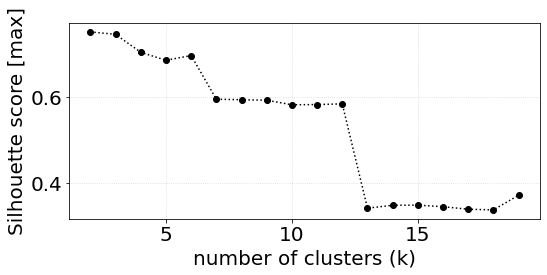

In [15]:
matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()

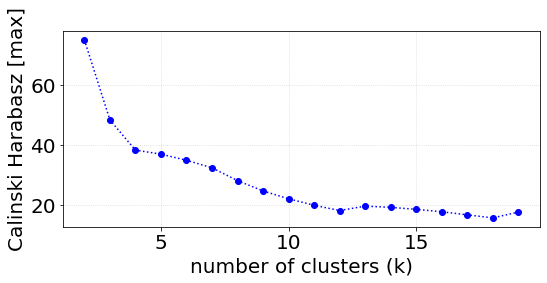

In [16]:
matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()

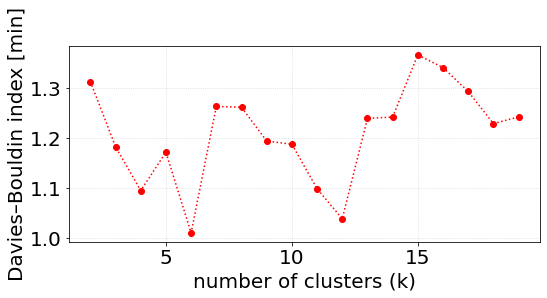

In [17]:
matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()
